# Generative Models

## GANs & VAE



In this notebook, we are going to implement Variational AutoEncoder (VAE) and Generative Adversarial Network (GAN) on the MNIST dataset. VAEs learn a latent variable model from input data. They sample from this distribution and decode it to generate new data. GANs uses a generator to make images based on a prior distribution.




In [ ]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [ ]:
transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5),
    ])

In [ ]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 41336990.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1225623.19it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9586365.13it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8014526.20it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
num_threads =2
batch_size =32

train_loader =DataLoader(dataset=train_data,batch_size=batch_size,shuffle=True)

val_loader =DataLoader(dataset=valid_data,batch_size=batch_size,shuffle=True)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()


        self.fc1=nn.Linear(input_dim,hidden_dim)
        self.fc2=nn.Linear(hidden_dim,latent_dim)

        self.mean_layer=nn.Linear(latent_dim,2)
        self.log_var=nn.Linear(latent_dim,2)



    def forward(self, x):


        x=F.leaky_relu(self.fc1(x))
        x=F.leaky_relu(self.fc2(x))

        z_mean=self.mean_layer(x)
        z_log_var=self.log_var(x)


        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()


        self.fc1=nn.Linear(2,latent_dim)
        self.fc2=nn.Linear(latent_dim,hidden_dim)
        self.fc3=nn.Linear(hidden_dim,output_dim)


    def forward(self, z):

        out=F.leaky_relu(self.fc1(z))
        out=F.leaky_relu(self.fc2(out))
        x=F.leaky_relu(self.fc3(out))
        return F.sigmoid(x)

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def forward(self, x):

        z_mean,z_log_var=self.encoder(x)

        epsilon=torch.randn_like(z_log_var)

        z=z_mean+z_log_var*epsilon
        image=self.decoder(z)

        return image, z_mean, z_log_var

In [ ]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images.view(-1,784))
    return recon_images

In [ ]:
def loss_func(x,x_hat,z_mean,z_log_var):
    reproduction_loss=F.binary_cross_entropy(x_hat,x,reduction='sum')
    #KL:
    kl=-0.5*torch.sum(1+z_log_var-z_mean.pow(2) -z_log_var.exp() )
    LOSS=kl+reproduction_loss
    return LOSS

In [ ]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-3, num_epochs=100,device=DEVICE):

    model =VAE(input_dim,hidden_dim,latent_dim).to(device) #
    optimizer =torch.optim.Adam(model.parameters(),lr=learning_rate)

    sample_images, _ = next(iter(val_loader))
    sample_images = sample_images.to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        recon_image = reconstruct_images(model, sample_images)
        recon_image=recon_image.view(-1,1,28,28)
        plt.figure(figsize=(4,4))
        plt.subplot(1,4,1)
        plt.imshow(recon_image[0].reshape(28,28).detach().cpu().numpy(),cmap="gray")
        plt.axis('off')
        plt.subplot(1,4,2)
        plt.imshow(recon_image[1].reshape(28,28).detach().cpu().numpy(),cmap="gray")
        plt.axis('off')
        plt.subplot(1,4,3)
        plt.imshow(recon_image[2].reshape(28,28).detach().cpu().numpy(),cmap="gray")
        plt.axis('off')
        plt.subplot(1,4,4)
        plt.imshow(recon_image[3].reshape(28,28).detach().cpu().numpy(),cmap="gray")
        plt.axis('off')
        plt.show()

        model.train()
        train_loss = 0.0
        # print(f"epoch:{epoch+1}")
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:


                x=data[0].to(device)
                x=x.view(-1,28*28)
                optimizer.zero_grad()
                x_hat,mean,log_var=model(x)
                loss=loss_func(x,x_hat,mean,log_var)
                train_loss+=loss.item()
                loss.backward()
                optimizer.step()
            print('Loss: {:.4f}'.format(train_loss / len(dataloader.dataset)))



    return model

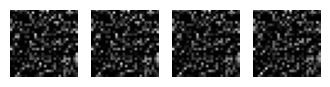

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 254.3507


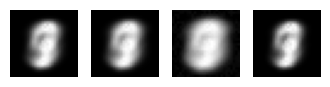

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 197.8932


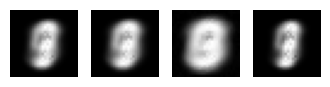

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 193.6563


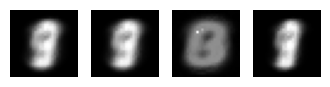

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 190.6420


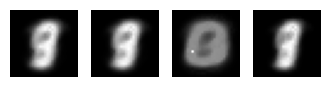

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 188.9971


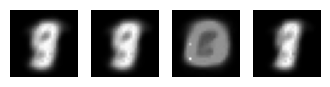

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 188.0072


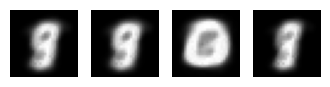

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 187.3678


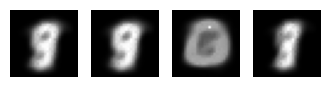

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 186.9201


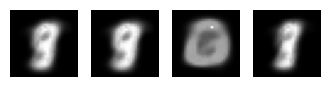

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 186.6313


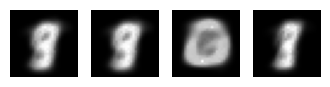

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 185.5887


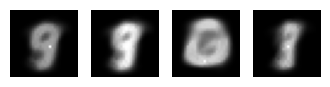

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 183.1097


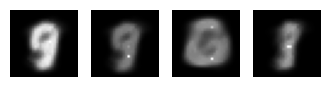

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 180.9184


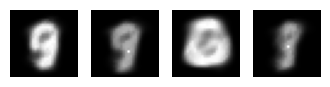

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 178.8747


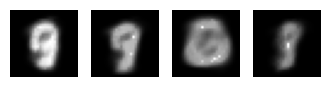

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 177.1774


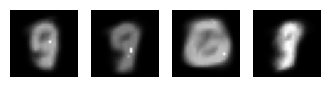

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 176.1328


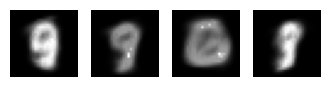

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 175.0106


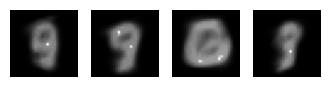

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 173.8855


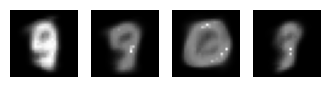

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 172.9278


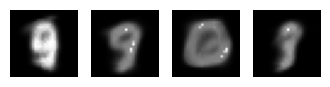

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 172.1666


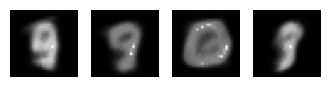

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 171.6167


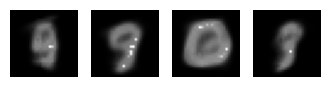

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 171.0357


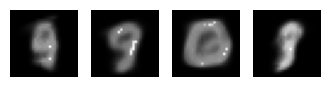

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 170.7185


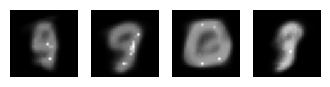

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 170.0511


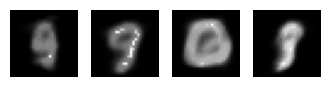

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 169.6751


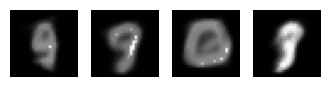

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 169.2668


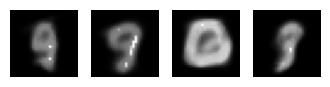

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 168.8919


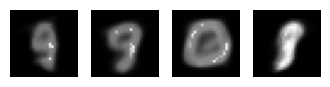

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 168.6983


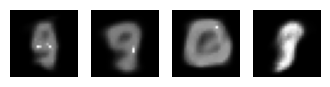

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 168.2535


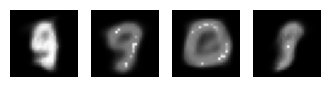

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 167.8679


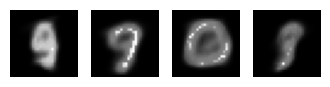

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 167.7110


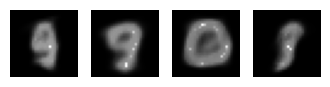

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 167.2363


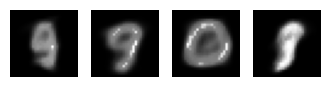

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 167.0349


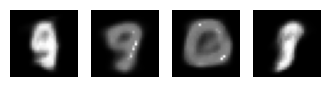

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 166.6708


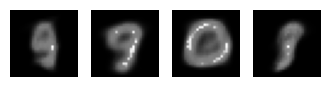

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 166.7174


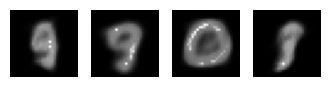

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 166.2821


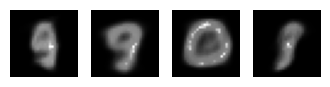

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 166.0048


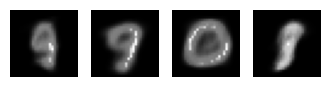

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 165.7786


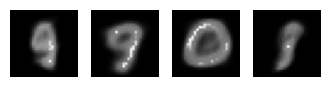

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 165.7599


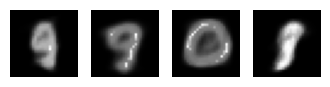

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 165.3638


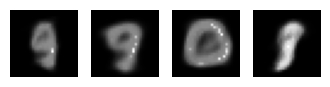

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 165.1831


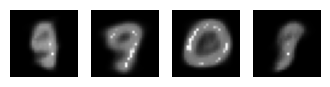

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 165.0534


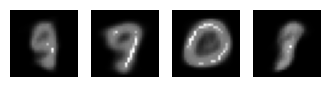

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 164.8319


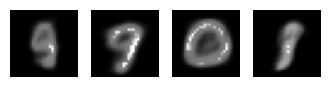

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 164.5628


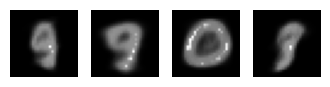

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 164.3565


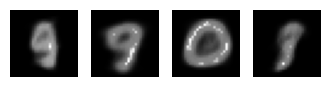

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 164.3390


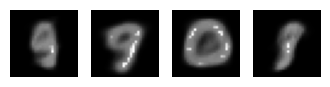

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 164.0862


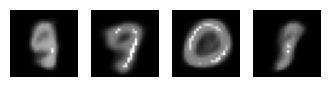

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.9038


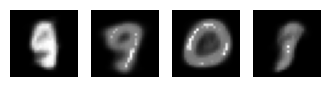

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.7648


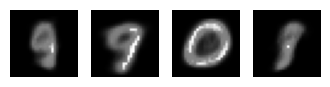

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.6305


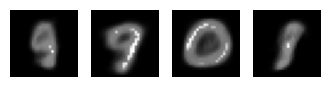

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.5059


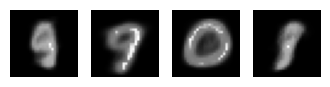

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.5502


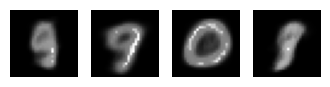

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.2181


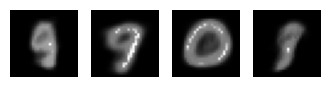

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 163.1003


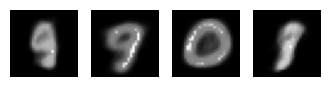

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.8675


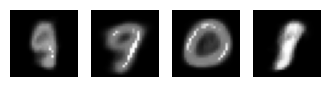

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.8185


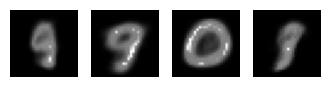

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.5829


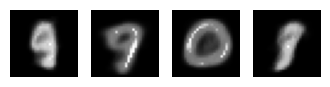

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.4607


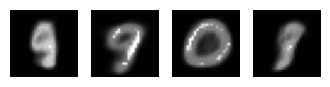

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.3712


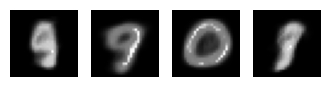

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.3496


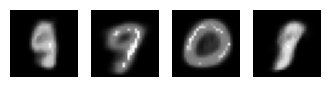

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.1900


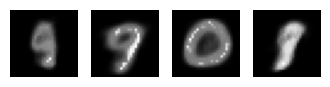

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 162.1197


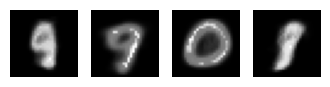

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.9094


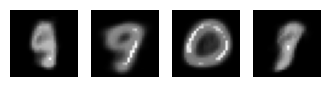

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.7585


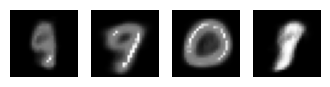

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.6798


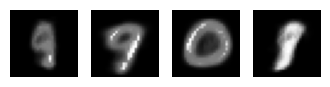

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.6057


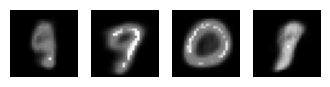

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.4710


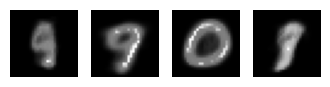

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.3627


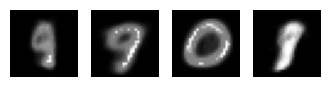

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.2779


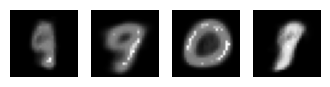

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.1059


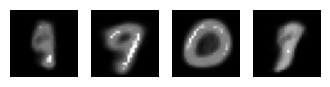

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 161.0622


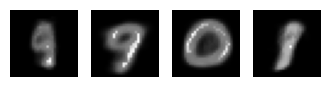

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.9419


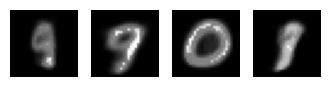

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.8560


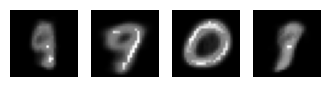

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.7664


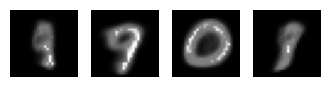

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.5979


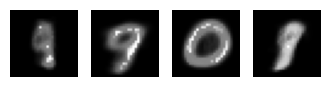

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.6027


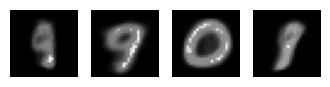

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.4919


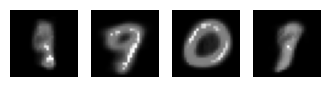

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.4097


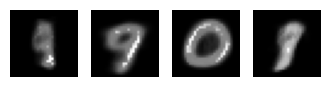

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.2313


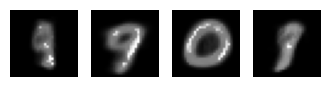

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.1453


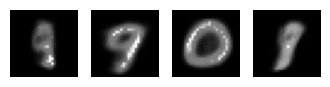

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.1239


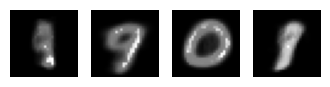

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 160.0652


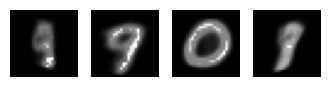

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.9918


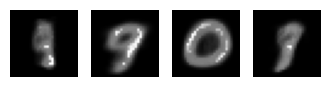

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.7847


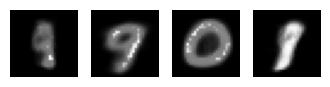

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.9227


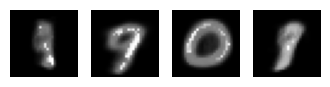

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.6045


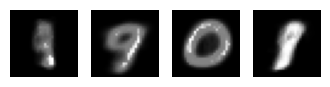

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.6605


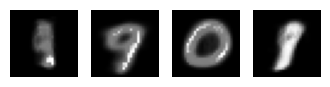

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.5418


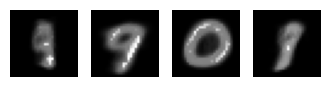

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.5857


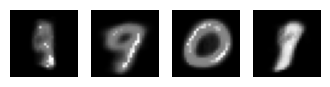

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.3103


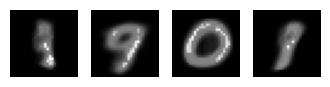

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.2626


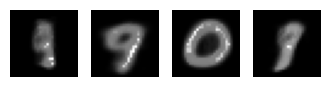

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.2705


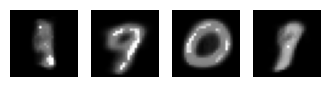

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.2303


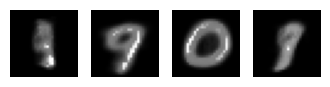

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.1128


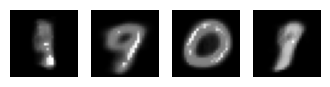

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 159.0393


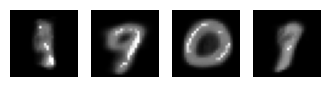

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 158.9845


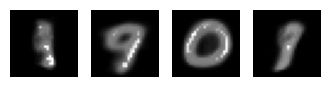

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 158.8923


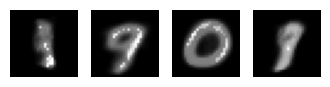

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 158.7565


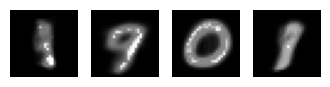

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 158.6916


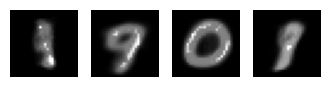

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 158.6950


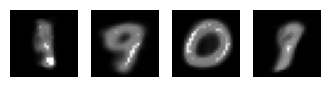

  0%|          | 0/1563 [00:00<?, ?it/s]

Loss: 158.5997


In [ ]:
model = train_vae(dataloader=train_loader, latent_dim=2, hidden_dim=400, input_dim=784)

In [ ]:
def plot_latent_space(model,scale=1,n=25,digit_size=28,figsize=8):
    figure=np.zeros((digit_size*n,digit_size*n))

    grid_x=np.linspace(-scale,scale,n)
    grid_y=np.linspace(-scale,scale,n)[::-1]

    for i,yi in enumerate(grid_y):
        for j , xi in enumerate(grid_x):
            z_sample=torch.tensor([[xi,yi]],dtype=torch.float).to(DEVICE)
            x_decoded=model.decoder(z_sample)
            digit=x_decoded[0].detach().cpu().reshape(digit_size,digit_size)
            figure[i*digit_size:(i+1)*digit_size,j*digit_size:(j+1)*digit_size]=digit
    plt.figure(figsize=(figsize,figsize))
    plt.title('VAE laten space visualization')
    start_range=digit_size//2
    end_range=n*digit_size+start_range
    pixel_range=np.arange(start_range,end_range,digit_size)
    sample_range_x=np.round(grid_x,1)
    sample_range_y=np.round(grid_y,1)
    plt.xticks(pixel_range,sample_range_x)
    plt.yticks(pixel_range,sample_range_y)
    plt.xlabel("mean,z [0]")
    plt.ylabel('var , z[1]')
    plt.imshow(figure,cmap="Greys_r")
    plt.show()


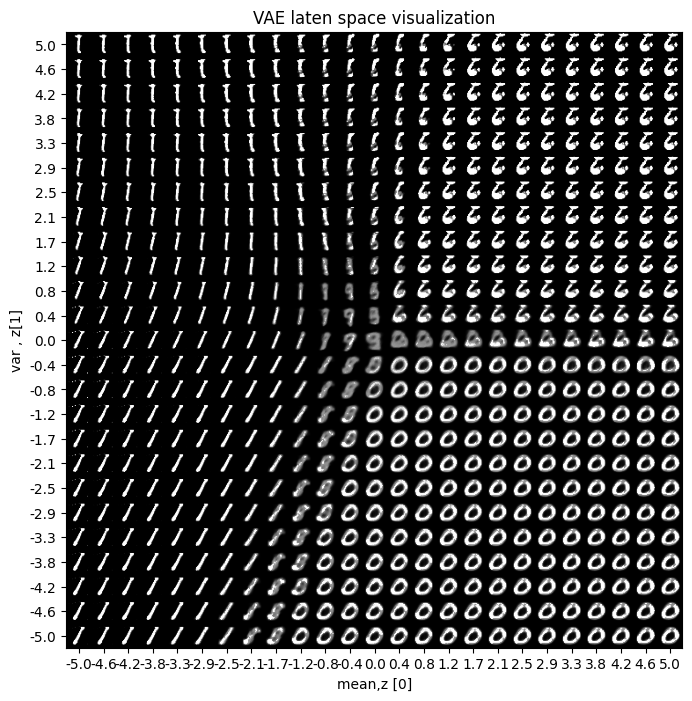

In [ ]:
with torch.no_grad():
  plot_latent_space(model,scale=5)

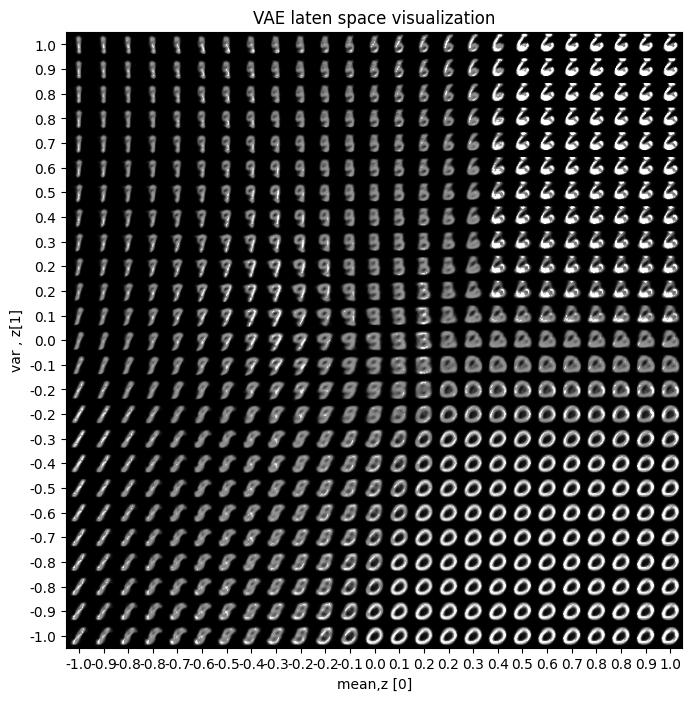

In [ ]:
with torch.no_grad():
  plot_latent_space(model,scale=1)

# GAN

GANs consist of two models: a generator and a discriminator. The generator creates new data points, and the discriminator evaluates them, trying to distinguish between real and generated (fake) data points. The training process involves updating the generator to produce more realistic data, as judged by the discriminator, and simultaneously updating the discriminator to get better at distinguishing real from fake. This adversarial process leads to improvements in both models, with the generator producing highly realistic data points as a result.

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, img_shape=(1,28,28),batch_size=batch_size):
        super(Generator, self).__init__()



        self.latent_dim=latent_dim
        self.img_shape = img_shape
        self.batch_size=batch_size
        # self.model = nn.Sequential(nn.ConvTranspose2d(self.latent_dim,128,2,2),nn.BatchNorm2d(128),nn.ReLU(),
        #                            nn.ConvTranspose2d(128,64,2,2),nn.BatchNorm2d(64),nn.ReLU(),
        #                            nn.ConvTranspose2d(64,32,4,1),nn.BatchNorm2d(32),nn.ReLU(),
        #                            nn.ConvTranspose2d(32,16,2,2),nn.BatchNorm2d(16),nn.ReLU(),
        #                            nn.ConvTranspose2d(16,1,2,2)
        #                             )
        self.model = nn.Sequential(nn.Linear(self.latent_dim,128),nn.LeakyReLU(),nn.Linear(128,400),nn.LeakyReLU(),
                                   nn.Linear(400,784),nn.Tanh())

    def forward(self, z):

        img=self.model(z)

        return img.view(-1,1,28,28)

class Discriminator(nn.Module):
    def __init__(self, img_dim=(1,28,28),batch_size=batch_size):
        super(Discriminator, self).__init__()


        self.batch_size=batch_size
        # self.model = nn.Sequential(nn.Conv2d(1,16,2,2),nn.BatchNorm2d(16),nn.LeakyReLU(),
                                  #  nn.Conv2d(16,32,2,2),nn.BatchNorm2d(32),nn.LeakyReLU(),
                                  #  nn.Conv2d(32,16,3,2,1),nn.BatchNorm2d(16),nn.LeakyReLU(),
                                  #  nn.Conv2d(16,1,4,1),nn.BatchNorm2d(1),nn.LeakyReLU())
        self.model=nn.Sequential(nn.Linear(784,400),nn.LeakyReLU(),nn.Linear(400,128),
                                 nn.LeakyReLU(),nn.Linear(128,1),nn.Sigmoid())

    def forward(self, img):

        flat=img.view(img.shape[0],-1)


        x =self.model(flat)

        return x

In [ ]:
def train_gan(dataloader, latent_dim, img_shape=(1, 28, 28), learning_rate=3e-4, num_epochs=100):

    generator =Generator(latent_dim).to(DEVICE)
    discriminator =Discriminator().to(DEVICE)
    adversarial_loss =nn.BCELoss().to(DEVICE)
    optimizer_G =torch.optim.Adam(generator.parameters(), lr=learning_rate)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
    reall = 1
    fakel = 0
    for epoch in range(num_epochs):
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, (imgs, _) in pbar:
                imgs=imgs.to(DEVICE)
                # imgs=imgs.type(torch.FloatTensor).to(DEVICE)

                # valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(DEVICE)
                # fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(DEVICE)
                real_label = torch.full((imgs.shape[0],1), reall, dtype=imgs.dtype, device=DEVICE)
                fake_label = torch.full((imgs.shape[0],1), fakel, dtype=imgs.dtype, device=DEVICE)
                # Configure input
                # real_imgs = imgs.type(torch.FloatTensor)
                # real_imgs=real_imgs.to(DEVICE)
                # -----------------
                #  Train Generator
                # -----------------
                optimizer_G.zero_grad()

                # Sample noise as generator input
                z = torch.randn(imgs.shape[0],latent_dim).to(DEVICE)
                gen_imgs=generator(z)

                # Loss measures generator's ability to fool the discriminator
                DGZ=discriminator(gen_imgs)
                g_loss = adversarial_loss(DGZ, real_label)
                g_loss.backward()
                optimizer_G.step()

                # ---------------------
                #  Train Discriminator
                # ---------------------
                # z_ = torch.randn(imgs.shape[0], 256, 1, 1).to(DEVICE)
                optimizer_D.zero_grad()
                # fake_images = generator(z_)


                bad = discriminator(gen_imgs.detach())
                good = discriminator(imgs)

                d_loss_bad = adversarial_loss(bad,fake_label)
                d_loss_good = adversarial_loss(good, real_label)
                d_loss = (d_loss_bad+d_loss_good)/2
                d_loss.backward()
                optimizer_D.step()





                pbar.set_description("[epoch: {}/{}] [D loss: {:.4f}] [G loss: {:.4f}]".format(epoch, num_epochs, d_loss.item(), g_loss.item()))


        # Ploting generated images after each epoch
        with torch.no_grad():
            z = torch.randn(4,latent_dim).to(DEVICE)
            gen_imgs = generator(z)
            plt.figure(figsize=(4, 9))
            for i in range(4):
                plt.subplot(1, 4, i+1)
                plt.imshow(gen_imgs[i].detach().cpu().numpy().transpose(1, 2, 0), cmap='gray')
                plt.axis('off')
            plt.show()

    return generator, discriminator

  0%|          | 0/1563 [00:00<?, ?it/s]

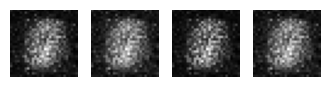

  0%|          | 0/1563 [00:00<?, ?it/s]

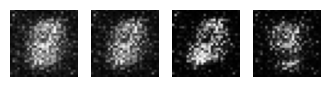

  0%|          | 0/1563 [00:00<?, ?it/s]

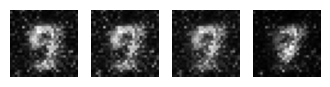

  0%|          | 0/1563 [00:00<?, ?it/s]

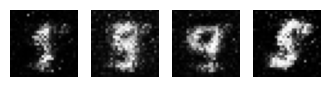

  0%|          | 0/1563 [00:00<?, ?it/s]

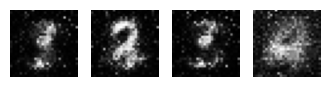

  0%|          | 0/1563 [00:00<?, ?it/s]

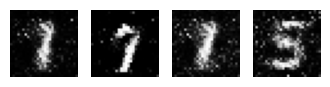

  0%|          | 0/1563 [00:00<?, ?it/s]

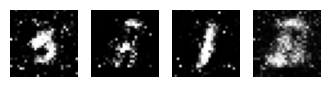

  0%|          | 0/1563 [00:00<?, ?it/s]

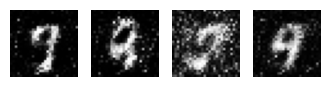

  0%|          | 0/1563 [00:00<?, ?it/s]

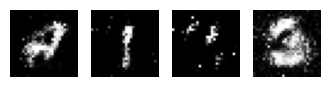

  0%|          | 0/1563 [00:00<?, ?it/s]

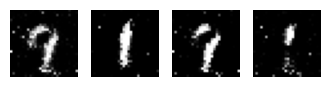

  0%|          | 0/1563 [00:00<?, ?it/s]

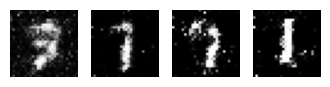

  0%|          | 0/1563 [00:00<?, ?it/s]

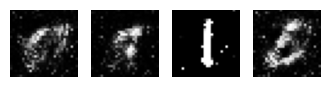

  0%|          | 0/1563 [00:00<?, ?it/s]

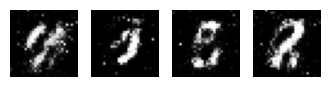

  0%|          | 0/1563 [00:00<?, ?it/s]

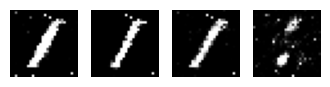

  0%|          | 0/1563 [00:00<?, ?it/s]

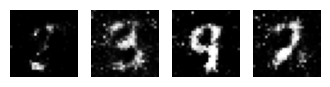

  0%|          | 0/1563 [00:00<?, ?it/s]

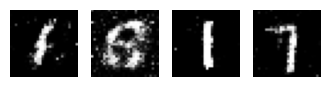

  0%|          | 0/1563 [00:00<?, ?it/s]

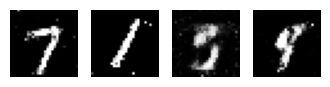

  0%|          | 0/1563 [00:00<?, ?it/s]

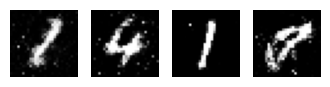

  0%|          | 0/1563 [00:00<?, ?it/s]

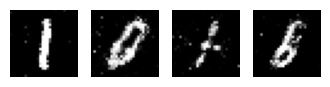

  0%|          | 0/1563 [00:00<?, ?it/s]

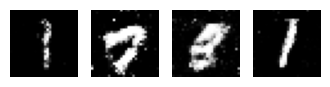

  0%|          | 0/1563 [00:00<?, ?it/s]

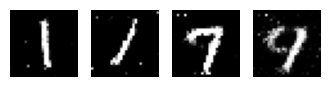

  0%|          | 0/1563 [00:00<?, ?it/s]

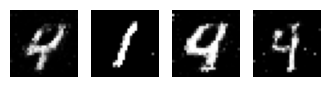

  0%|          | 0/1563 [00:00<?, ?it/s]

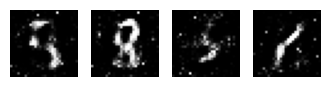

  0%|          | 0/1563 [00:00<?, ?it/s]

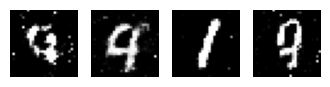

  0%|          | 0/1563 [00:00<?, ?it/s]

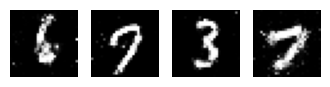

  0%|          | 0/1563 [00:00<?, ?it/s]

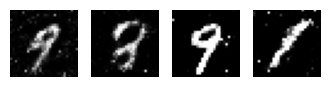

  0%|          | 0/1563 [00:00<?, ?it/s]

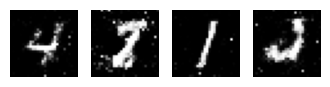

  0%|          | 0/1563 [00:00<?, ?it/s]

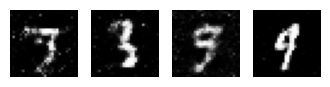

  0%|          | 0/1563 [00:00<?, ?it/s]

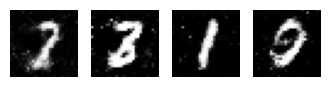

  0%|          | 0/1563 [00:00<?, ?it/s]

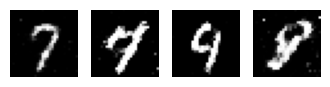

  0%|          | 0/1563 [00:00<?, ?it/s]

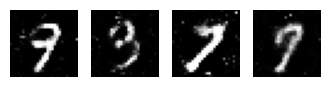

  0%|          | 0/1563 [00:00<?, ?it/s]

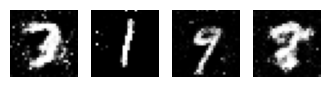

  0%|          | 0/1563 [00:00<?, ?it/s]

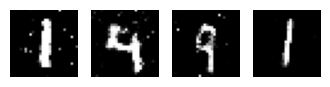

  0%|          | 0/1563 [00:00<?, ?it/s]

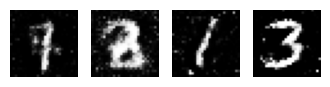

  0%|          | 0/1563 [00:00<?, ?it/s]

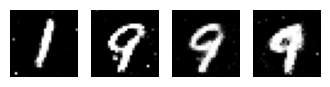

  0%|          | 0/1563 [00:00<?, ?it/s]

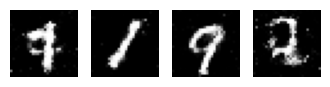

  0%|          | 0/1563 [00:00<?, ?it/s]

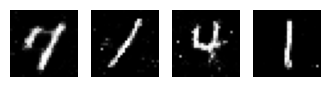

  0%|          | 0/1563 [00:00<?, ?it/s]

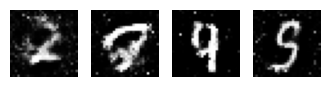

  0%|          | 0/1563 [00:00<?, ?it/s]

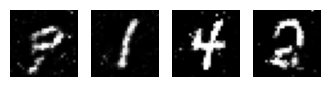

  0%|          | 0/1563 [00:00<?, ?it/s]

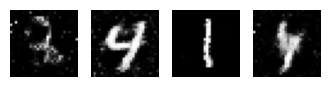

  0%|          | 0/1563 [00:00<?, ?it/s]

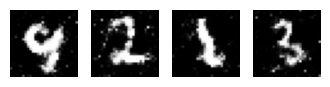

  0%|          | 0/1563 [00:00<?, ?it/s]

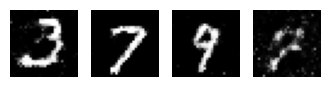

  0%|          | 0/1563 [00:00<?, ?it/s]

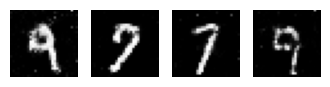

  0%|          | 0/1563 [00:00<?, ?it/s]

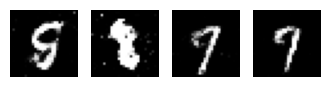

  0%|          | 0/1563 [00:00<?, ?it/s]

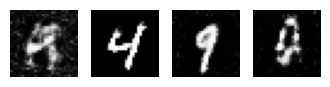

  0%|          | 0/1563 [00:00<?, ?it/s]

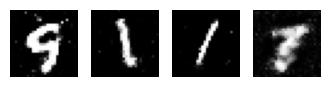

  0%|          | 0/1563 [00:00<?, ?it/s]

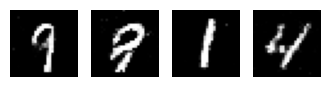

  0%|          | 0/1563 [00:00<?, ?it/s]

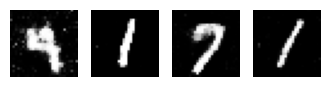

  0%|          | 0/1563 [00:00<?, ?it/s]

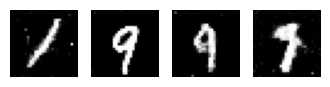

  0%|          | 0/1563 [00:00<?, ?it/s]

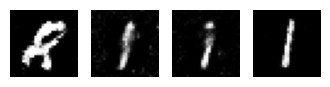

  0%|          | 0/1563 [00:00<?, ?it/s]

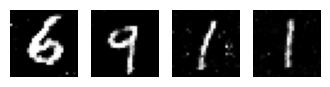

  0%|          | 0/1563 [00:00<?, ?it/s]

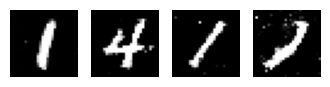

  0%|          | 0/1563 [00:00<?, ?it/s]

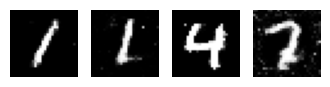

  0%|          | 0/1563 [00:00<?, ?it/s]

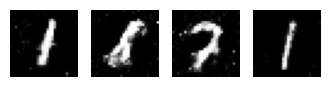

  0%|          | 0/1563 [00:00<?, ?it/s]

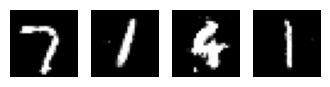

  0%|          | 0/1563 [00:00<?, ?it/s]

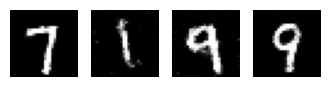

  0%|          | 0/1563 [00:00<?, ?it/s]

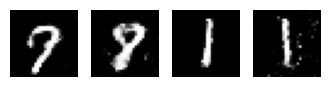

  0%|          | 0/1563 [00:00<?, ?it/s]

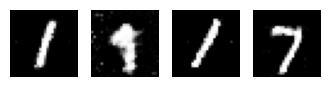

  0%|          | 0/1563 [00:00<?, ?it/s]

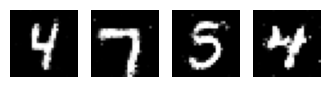

  0%|          | 0/1563 [00:00<?, ?it/s]

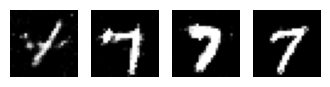

  0%|          | 0/1563 [00:00<?, ?it/s]

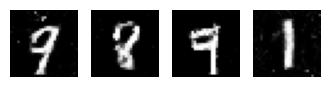

  0%|          | 0/1563 [00:00<?, ?it/s]

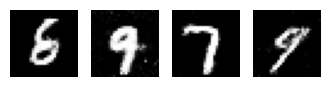

  0%|          | 0/1563 [00:00<?, ?it/s]

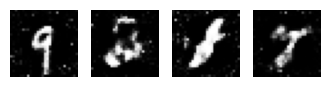

  0%|          | 0/1563 [00:00<?, ?it/s]

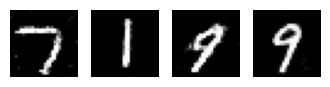

  0%|          | 0/1563 [00:00<?, ?it/s]

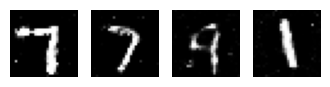

  0%|          | 0/1563 [00:00<?, ?it/s]

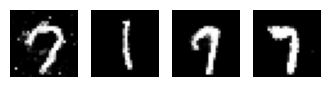

  0%|          | 0/1563 [00:00<?, ?it/s]

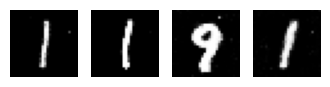

  0%|          | 0/1563 [00:00<?, ?it/s]

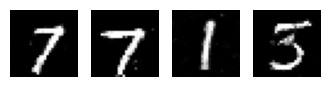

  0%|          | 0/1563 [00:00<?, ?it/s]

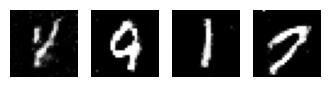

  0%|          | 0/1563 [00:00<?, ?it/s]

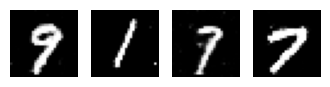

  0%|          | 0/1563 [00:00<?, ?it/s]

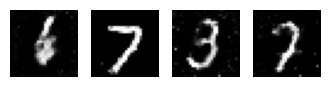

  0%|          | 0/1563 [00:00<?, ?it/s]

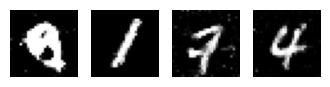

  0%|          | 0/1563 [00:00<?, ?it/s]

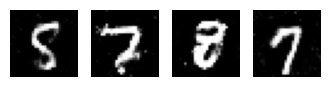

  0%|          | 0/1563 [00:00<?, ?it/s]

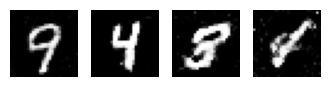

  0%|          | 0/1563 [00:00<?, ?it/s]

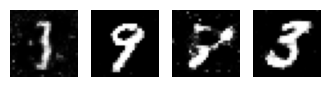

  0%|          | 0/1563 [00:00<?, ?it/s]

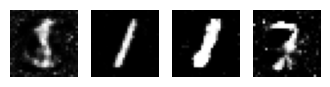

  0%|          | 0/1563 [00:00<?, ?it/s]

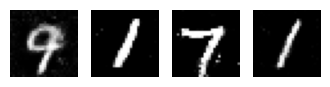

  0%|          | 0/1563 [00:00<?, ?it/s]

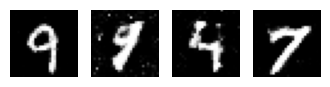

  0%|          | 0/1563 [00:00<?, ?it/s]

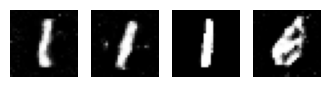

  0%|          | 0/1563 [00:00<?, ?it/s]

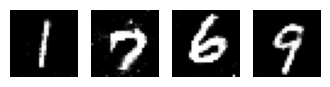

  0%|          | 0/1563 [00:00<?, ?it/s]

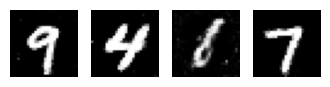

  0%|          | 0/1563 [00:00<?, ?it/s]

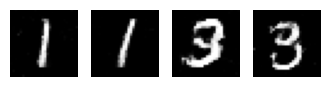

  0%|          | 0/1563 [00:00<?, ?it/s]

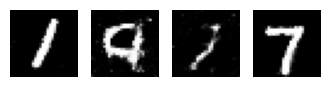

  0%|          | 0/1563 [00:00<?, ?it/s]

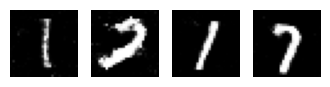

  0%|          | 0/1563 [00:00<?, ?it/s]

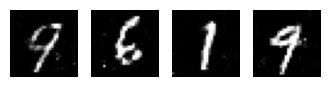

  0%|          | 0/1563 [00:00<?, ?it/s]

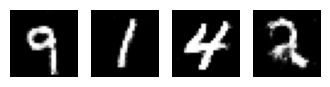

  0%|          | 0/1563 [00:00<?, ?it/s]

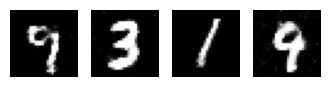

  0%|          | 0/1563 [00:00<?, ?it/s]

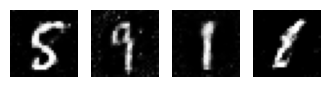

  0%|          | 0/1563 [00:00<?, ?it/s]

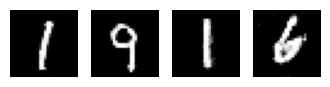

  0%|          | 0/1563 [00:00<?, ?it/s]

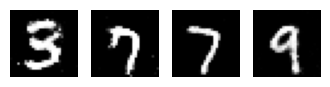

  0%|          | 0/1563 [00:00<?, ?it/s]

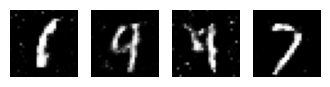

  0%|          | 0/1563 [00:00<?, ?it/s]

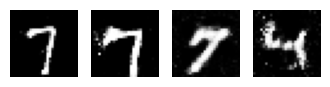

  0%|          | 0/1563 [00:00<?, ?it/s]

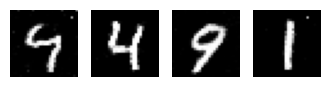

  0%|          | 0/1563 [00:00<?, ?it/s]

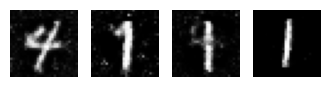

  0%|          | 0/1563 [00:00<?, ?it/s]

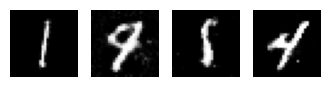

  0%|          | 0/1563 [00:00<?, ?it/s]

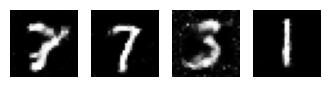

  0%|          | 0/1563 [00:00<?, ?it/s]

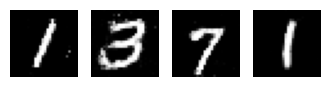

  0%|          | 0/1563 [00:00<?, ?it/s]

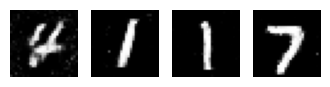

  0%|          | 0/1563 [00:00<?, ?it/s]

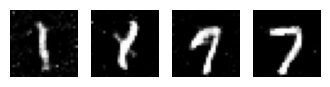

  0%|          | 0/1563 [00:00<?, ?it/s]

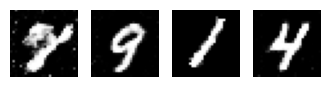

In [ ]:
generator, discriminator = train_gan(dataloader=train_loader, latent_dim=256) ## todo

# Compare

Using validation dataset to plot and compare the results of trained models.

### on VALIDATION

           VALIDATION DATASET (REAL IMAGES)


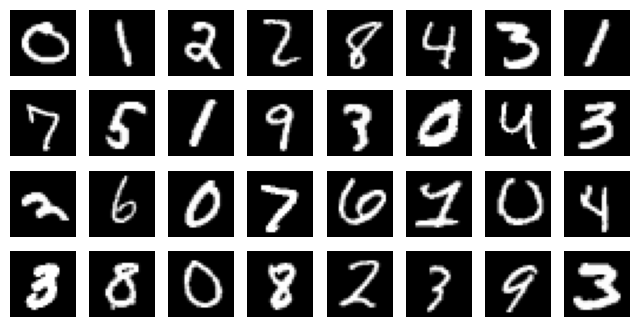

In [ ]:

for val_i,_ in val_loader:
  break
plt.figure(figsize=(8,4))
for i, img in enumerate(val_i):

  plt.subplot(4,8,i+1)
  plt.imshow(val_i[i].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
  plt.axis('off')
print("           VALIDATION DATASET (REAL IMAGES)")
plt.show()

##on GAN MODEL

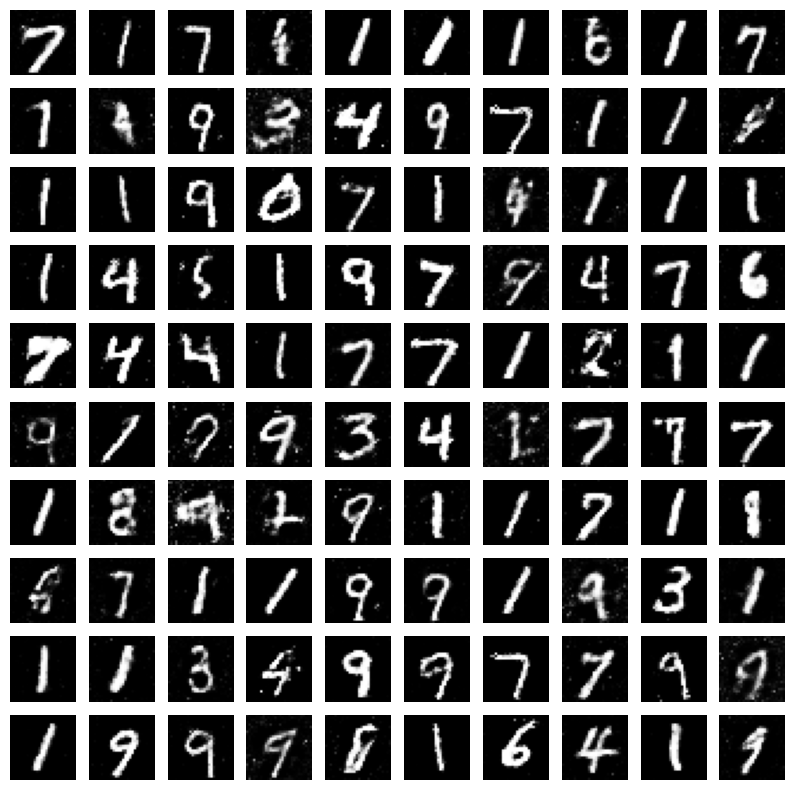

In [ ]:
z1=torch.randn(100,256)
with torch.no_grad():
    plt.figure(figsize=(10,10))
    fake_img=generator(z1)
    for i, fake_im in enumerate(fake_img):

        plt.subplot(10,10,i+1)
        plt.imshow(fake_img[i].detach().cpu().numpy().transpose(1,2,0),cmap='gray')
        plt.axis('off')
    plt.show()
